# A python implementation in rust
## Windel Bouwman
## europython 2018


# whoami

- Software engineer
- python and open source enthusiast
- main author of ppci
- twitter: @windelbouwman
- github: github.com/windelbouwman


# What is rust

- A relatively new programming language
- Same target audience as C/C++
- Prevents many common errors such as:
  - buffer overflows
  - memory leaks
- Staticly typed
- No garbage collection
- Developed by mozilla and used in firefox

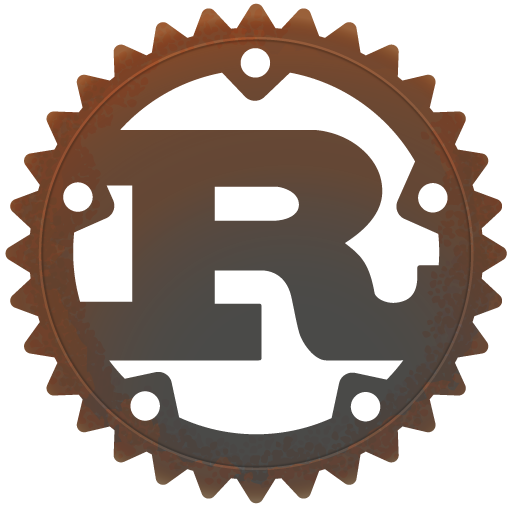


# What is the problem with C, why do we need rust?

- It is a complex language
- A mistake is easily made
- There is not really package / dependency management like pip, npm, conda
- The larger the application, the harder memory problems become to pinpoint

To many new C/C++ programmers the following comes as a surprise:

## Code
```c
#include <stdio.h>

struct {
  int data[10];
  int zero;
} my_data;

int main() {
  my_data.zero = 0;
  for (int i=0;i<=10;i++)
    my_data.data[i] = i;
  printf("zero = %i\n", my_data.zero);
}

```
https://repl.it/repls/EvilAdoredCleantech

## Result
```
zero = 10
```

Wait, no error? What did it do?

# So how does rust address this issue?

# Example

```rust
struct MyStruct {
  data: Vec<i32>,
  zero: i32,
}

fn main() {
  let mut my_data = MyStruct {
    data: vec!(),
    zero: 0,
  };
  for i in 0..10 {
    my_data.data.push(i);
  }
  println!("zero = {:?}", my_data.zero);
}

```

https://repl.it/repls/GruesomeLovelyProgrammer

## Result
```
zero = 0
```

# Other benefits

- Rust has more benefits



## The developer environment

- A build and dependency manager cargo (think of pip + make)
- Built in support for unittests

## The rust webassembly hype

- There are a lot of javascript developers
- Javascript programmers are moving to webassembly and rust
- This means: a lot of rust programmers coming up

# Why use C to develop an application

- C is used to develop kernel and drivers
  - We need close access to hardware
  - We need access to memory and pointers

- Most of the time it is better to create an application with C#, java, python, ... anything but C/C++
  - An application contains so much logic, it is more important that it can be understood than that it is fast

- We do not need all the power given by C for most applications

- But Python itself is implemented in C... (CPython)


# How does python work?

- Lets take a look at some C-api reference documentation

```
PyObject* PyDict_GetItem(PyObject *p, PyObject *key)
    Return value: Borrowed reference.

    Return the object from dictionary p which has a key key. Return NULL if the key key is not present, but without setting an exception.
```


- How does this map to rust?
     - In rust we have ownership and borrowing. The compiler contains a borrow checker.
     - In rust there exists the Rc (reference counting type) to do reference counting.
     - In rust, we have the Result type to indicate recoverable errors

# Lets try this out

- I set out on an experiment called rspython (https://github.com/windelbouwman/rspython)
- But wait, there must be more people with this idea?

Yes there are!

# Enter rustpython

- re-implementation of python in rust
- Idea:
  - Benefit from the usage of rust
      - Unicode strings
      - build, dependency manager and unittest support out of the box
      - Have reference counting with `Rc` and exceptions with `Result` types
  - Closely look at lessons learned in cpython over multiple decades
  - Use rust libraries to implement libraries such as regex

https://github.com/RustPython/RustPython


# The design

- Follows the cpython design
- A lexer, parser and then an abstract syntax tree (AST) for python sourcecode
- A compiler from AST to bytecode
- A virtualmachine which can run this bytecode

<img src="images/python_design.svg" />

# Lexer

- Handwritten lexer
- Introduce indent / dedent tokens to deals with whitespace

# Parser

- Use lalrpop to generate a parser from a grammar
- Take tokens and turn them into an abstract syntax tree

# Ast (abstract syntax tree)

- The ast will contain the parsed program

```rust

#[derive(Debug, PartialEq)]
pub enum Statement {
    If {
        test: Expression,
        body: Vec<Statement>,
        orelse: Option<Vec<Statement>>,
    },
    Break,
    ...
}

pub enum Expression {
    Binop {
        a: Box<Expression>,
        op: Operator,
        b: Box<Expression>,
    },
    ...
},
```

# Parser generator: LALRPOP

- Very powerful grammar to define syntax

```rust
IfStatement: ast::Statement = {
  "if" <t:Test> ":" <s1:Suite> <s2:("elif" Test ":" Suite)*> <s3:("else" ":" Suite)?> => {
    // Determine last else:
    let mut last = match s3 {
      Some(s) => Some(s.2),
      None => None,
    };

    // handle elif:
    for i in s2.into_iter().rev() {
      last = Some(vec![ast::Statement::If { test: i.1, body: i.3, orelse: last }]);
    }

    ast::Statement::If { test: t, body: s1, orelse: last }
  },
};
```

# Bytecode

- The python virtual machine operates on bytecodes.

In [2]:
import dis
def f(a, b):
    return a + b + 3
dis.dis(f.__code__)

  3           0 LOAD_FAST                0 (a)
              2 LOAD_FAST                1 (b)
              4 BINARY_ADD
              6 LOAD_CONST               1 (3)
              8 BINARY_ADD
             10 RETURN_VALUE


# Compiler

- Main purpose: take AST and produce bytecode

```rust
fn compile_expression(&mut self, expression: ast::Expression) {
        trace!("Compiling {:?}", expression);
        match expression {
            ast::Expression::Call { function, args } => {
                self.compile_expression(*function);
                let count = args.len();
                for arg in args {
                    self.compile_expression(arg)
                }
                self.emit(Instruction::CallFunction { count: count });
            }
            ast::Expression::Binop { a, op, b } => {
                self.compile_expression(*a);
                self.compile_expression(*b);

                // Perform operation:
                let i = match op {
                    ast::Operator::Add => bytecode::BinaryOperator::Add,
                    ast::Operator::Sub => bytecode::BinaryOperator::Subtract,
                    ... etc ...
                };
                let i = Instruction::BinaryOperation { op: i };
                self.emit(i);
}
```

# Virtual machine

- Maintain a stack of frames
- Per frame maintain a value stack
- For each instruction:
    - pop operands from value stack
    - Do proper operation
    - push value back on value stack

# Frame loop

- Run instructions until a return or an exception occurs.
- Use rust Result to return either a return value or an exception

```rust
    fn run_frame(&mut self, frame: Frame) -> PyResult {
        self.frames.push(frame);
        let value = loop {
            let result = self.execute_instruction();
            match result {
                None => {}
                Some(Ok(value)) => {
                    break Ok(value);
                }
                Some(Err(exception)) => {
                    match self.unwind_exception(exception) {
                        None => {},
                        Some(exception) => break Err(exception),
                    }
                }
            }
        };

        self.pop_frame();
        value
    }
```

# Instruction dispatch

```rust
    fn execute_instruction(&mut self) -> Option<PyResult> {
        let instruction = self.current_frame().fetch_instruction();
        trace!("  Executing op code: {:?}", instruction);
        match &instruction {
            bytecode::Instruction::Import { ref name } => self.import(name),
            bytecode::Instruction::LoadName { ref name } => self.load_name(name),
            ...
```

# Load name

```rust

    fn load_name(&mut self, name: &String) -> Option<PyResult> {
        // Lookup name in scope and put it onto the stack!
        if self.current_frame().locals.contains_key(name) {
            let obj = self.current_frame().locals.get_item(name);
            self.push_value(obj);
            None
        } else if self.builtins.contains_key(name) {
            let obj = self.builtins.get_item(name);
            self.push_value(obj);
            None
        } else {
            let name_error = PyObject::new(
                PyObjectKind::NameError {
                    name: name.to_string(),
                },
                self.get_type(),
            );
            Some(Err(name_error))
        }
    }

```

# Object model

- Python uses reference counting.
- In rust we have the `Rc` type (reference counting pointer) (https://doc.rust-lang.org/std/rc/struct.Rc.html)

```rust
pub type PyRef<T> = Rc<RefCell<T>>;
pub type PyObjectRef = PyRef<PyObject>;

pub struct PyObject {
    pub kind: PyObjectKind,
    pub typ: Option<PyObjectRef>,
    pub dict: HashMap<String, PyObjectRef>,
}

pub enum PyObjectKind {
    String { value: String },
    Integer { value: i32 },
    ..
}
```

# Performance

- So how does all this perform?
- Lets take a simple benchmark

```python
j = 0
while j < 1000:
    total = 0
    i = 0
    while i < 100:
        total += i
        i += 1
    j += 1
```

```bash
python snippets/perf_add.py                0.05s
cargo run snippets/perf_add.py             2.73s
cargo run --release snippets/perf_add.py   0.29s
```
- Non scientific conclusion: rustpython is 5.3 times slower

# Builtins
## How is the python `all` function implemented?

- Using rust's iterator

```rust

fn all(rt: &mut Executor, args: Vec<PyObjectRef>) -> PyResult {
    Ok(rt.new_bool(args.into_iter().all(|e| objbool::boolval(e))))
}
```

# Demo

- Hands on time!

- `cargo run`
- `RUST_LOG=trace cargo run`

# Current status

- Project is in pre-alpha state
- Some, not all syntax is supported
- Ideas for the virtual machine and rust api are far from complete

# Roadmap and ideas

- Build as web app using webassembly and cargo web
- Implement and test multithreading since we do not have a GIL
- Add a ipython kernel
- Grow community, since this project is a large task!


# That's all!

- We welcome new developers for rust python
- Checkout: https://github.com/RustPython/RustPython
- Chat with us at gitter https://gitter.im/rustpython/Lobby
- @windelbouwman
- https://github.com/windelbouwman/
